# Training loop draft 3 - Multiclass
J. Cristiano

This is the training loop thats gonna have all the moving parts in it:     
- Data Augmentation 
- Weighted Cross entropy loss
- Transfer learning

In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import v2
from PIL import Image, ImageDraw
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
from typing import Any, Dict, List, Literal, Union, Type

import torchvision.transforms.v2.functional as F
from torchvision.transforms import v2
from torchvision.transforms.v2._utils import (
    _check_padding_mode_arg,
    _get_fill,
    _setup_fill_arg,
    _FillType,
)


class PadSquare(v2.Transform):
    """Pad a non-square input to make it square by padding the shorter side to match the longer side.
    Args:
        fill (number or tuple or dict, optional): Pixel fill value used when the  ``padding_mode`` is constant.
            Default is 0. If a tuple of length 3, it is used to fill R, G, B channels respectively.
            Fill value can be also a dictionary mapping data type to the fill value, e.g.
            ``fill={tv_tensors.Image: 127, tv_tensors.Mask: 0}`` where ``Image`` will be filled with 127 and
            ``Mask`` will be filled with 0.
        padding_mode (str, optional): Type of padding. Should be: constant, edge, reflect or symmetric.
            Default is "constant".

            - constant: pads with a constant value, this value is specified with fill

            - edge: pads with the last value at the edge of the image.

            - reflect: pads with reflection of image without repeating the last value on the edge.
              For example, padding [1, 2, 3, 4] with 2 elements on both sides in reflect mode
              will result in [3, 2, 1, 2, 3, 4, 3, 2]

            - symmetric: pads with reflection of image repeating the last value on the edge.
              For example, padding [1, 2, 3, 4] with 2 elements on both sides in symmetric mode
              will result in [2, 1, 1, 2, 3, 4, 4, 3]

    Example:
        >>> import torch
        >>> from torchvision.transforms.v2 import PadSquare
        >>> rectangular_image = torch.randint(0, 255, (3, 224, 168), dtype=torch.uint8)
        >>> transform = PadSquare(padding_mode='constant', fill=0)
        >>> square_image = transform(rectangular_image)
        >>> print(square_image.size())
        torch.Size([3, 224, 224])
    """

    def __init__(
        self,
        fill: Union[_FillType, Dict[Union[Type, str], _FillType]] = 0,
        padding_mode: Literal["constant", "edge", "reflect", "symmetric"] = "constant",
    ):
        super().__init__()

        _check_padding_mode_arg(padding_mode)

        if padding_mode not in ["constant", "edge", "reflect", "symmetric"]:
            raise ValueError(
                "`padding_mode` must be one of 'constant', 'edge', 'reflect' or 'symmetric'."
            )
        self.padding_mode = padding_mode
        self.fill = _setup_fill_arg(fill)

    def _get_params(self, flat_inputs: List[Any]) -> Dict[str, Any]:
        # Get the original height and width from the inputs
        orig_height, orig_width = v2.query_size(flat_inputs)

        # Find the target size (maximum of height and width)
        target_size = max(orig_height, orig_width)

        if orig_height < target_size:
            # Need to pad height
            pad_height = target_size - orig_height
            pad_top = pad_height // 2
            pad_bottom = pad_height - pad_top
            pad_left = 0
            pad_right = 0
        else:
            # Need to pad width
            pad_width = target_size - orig_width
            pad_left = pad_width // 2
            pad_right = pad_width - pad_left
            pad_top = 0
            pad_bottom = 0

        # The padding needs to be in the format [left, top, right, bottom]
        return dict(padding=[pad_left, pad_top, pad_right, pad_bottom])

    def _transform(self, inpt: Any, params: Dict[str, Any]) -> Any:
        fill = _get_fill(self.fill, type(inpt))
        return self._call_kernel(
            F.pad,
            inpt,
            padding=params["padding"],
            padding_mode=self.padding_mode,
            fill=fill
        )

In [3]:
coco_root = '/work/2023_annot/images'
coco_annFile = '/work/2023_annot/2023_annotations.json'
standard_transform = transforms.v2.Compose([
    PadSquare(padding_mode='reflect'),
    v2.Resize((512, 512)), 
    v2.ToImage()
    ])
full_dataset = datasets.CocoDetection(root=coco_root, annFile=coco_annFile, transforms=standard_transform)
full_dataset = datasets.wrap_dataset_for_transforms_v2(full_dataset, target_keys=("boxes", "labels", "masks"))

train_size = int(0.8 * len(full_dataset))
test_size = int(0.2 * len(full_dataset))
test_size += len(full_dataset) - (train_size + test_size)
full_dataset.train, full_dataset.test = torch.utils.data.random_split(full_dataset, [train_size, test_size])

loading annotations into memory...
Done (t=0.14s)
creating index...
index created!


In [4]:
augmentations = transforms.v2.Compose([
    transforms.v2.RandomPerspective(distortion_scale=0.25, p=0.5),
    transforms.v2.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
    transforms.v2.RandomHorizontalFlip(p=0.5),
    transforms.v2.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),
    transforms.v2.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.v2.RandomRotation(degrees=5)
])

def custom_collate_fn(batch):
    # Unpack the batch - assuming each item is a (image, mask) tuple
    images, masks = zip(*batch)
    mask_batch = []
    for mask in masks:
        multiclass_mask = torch.zeros((4, mask["masks"].shape[1], mask["masks"].shape[2]), dtype=mask["masks"].dtype)
        for idx, label in enumerate(mask["labels"]):
            multiclass_mask[label] = mask["masks"][idx]
        multiclass_mask[0] = 1 - torch.max(multiclass_mask[1:], dim=0)[0]
        mask_batch.append(multiclass_mask)

    return images, mask_batch

full_dataset.train.transforms = transforms.v2.Compose([standard_transform, augmentations])
train_dataloader = DataLoader(
    full_dataset.train, 
    batch_size=8, 
    shuffle=True, 
    num_workers=2,
    collate_fn=custom_collate_fn)
test_dataloader = DataLoader(
    full_dataset.test, 
    batch_size=8, 
    shuffle=True, 
    num_workers=2,
    collate_fn=custom_collate_fn)

In [5]:
# Calculate class weights for weighted cross entropy
class_counts = torch.zeros(4)
total_pixels = 0
print("Calculating class imbalances")
for _, masks in tqdm(train_dataloader):
    for mask in masks:
        for i in range(4):
            class_counts[i] += mask[i].sum()
        total_pixels += mask[0].numel()
class_weights = 1.0 / (class_counts + 1e-8)  # add small epsilon to avoid division by zero
class_weights = class_weights / class_weights.sum() * len(class_weights)  # normalize weights
print(f"Class weights: {class_weights}")

Calculating class imbalances


  0%|                                                                                                                                                                | 0/11 [00:00<?, ?it/s]


ValueError: Caught ValueError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/opt/sam2_env/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 351, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/opt/sam2_env/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 50, in fetch
    data = self.dataset.__getitems__(possibly_batched_index)
  File "/opt/sam2_env/lib/python3.10/site-packages/torch/utils/data/dataset.py", line 420, in __getitems__
    return [self.dataset[self.indices[idx]] for idx in indices]
  File "/opt/sam2_env/lib/python3.10/site-packages/torch/utils/data/dataset.py", line 420, in <listcomp>
    return [self.dataset[self.indices[idx]] for idx in indices]
  File "/opt/sam2_env/lib/python3.10/site-packages/torchvision/tv_tensors/_dataset_wrapper.py", line 193, in __getitem__
    sample = self.transforms(*sample)
  File "/opt/sam2_env/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/sam2_env/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/sam2_env/lib/python3.10/site-packages/torchvision/transforms/v2/_container.py", line 51, in forward
    outputs = transform(*inputs)
  File "/opt/sam2_env/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/sam2_env/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/sam2_env/lib/python3.10/site-packages/torchvision/transforms/v2/_transform.py", line 50, in forward
    flat_outputs = [
  File "/opt/sam2_env/lib/python3.10/site-packages/torchvision/transforms/v2/_transform.py", line 51, in <listcomp>
    self._transform(inpt, params) if needs_transform else inpt
  File "/tmp/ipykernel_7629/2383283593.py", line 89, in _transform
    return self._call_kernel(
  File "/opt/sam2_env/lib/python3.10/site-packages/torchvision/transforms/v2/_transform.py", line 35, in _call_kernel
    return kernel(inpt, *args, **kwargs)
  File "/opt/sam2_env/lib/python3.10/site-packages/torchvision/transforms/v2/functional/_geometry.py", line 1352, in _pad_bounding_boxes_dispatch
    output, canvas_size = pad_bounding_boxes(
  File "/opt/sam2_env/lib/python3.10/site-packages/torchvision/transforms/v2/functional/_geometry.py", line 1330, in pad_bounding_boxes
    raise ValueError(f"Padding mode '{padding_mode}' is not supported with bounding boxes")
ValueError: Padding mode 'reflect' is not supported with bounding boxes


In [ ]:
#training loop 
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn
import torch.nn as nn


preprocess_input = get_preprocessing_fn('resnet18', pretrained='imagenet')
model = smp.Unet(
    encoder_name="resnet18",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=4,                      # model output channels (number of classes in your dataset)
)
model.to(device)
criterion = nn.CrossEntropyLoss(class_weights.to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
training_results = {
    "train_loss": [],
    "test_loss" : [], 
    "pocket_loss": None,
    "pocket_model": None,
}
for epoch in tqdm(range(20)):
    running_loss = 0.0
    for img, mask in train_dataloader:
        model.train()
        img = torch.stack([torch.tensor(preprocess_input(i.permute(1, 2, 0).numpy())) for i in img])
        img = img.permute(0, 3, 1, 2).float()
        result = model(img.to(device))
        mask = torch.stack(mask)
        loss = criterion(result.to(device), mask.float().to(device))
        running_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    training_results["train_loss"].append(running_loss/len(train_dataloader))
    running_loss = 0.0
    for img, mask in test_dataloader:
        model.eval()
        img = torch.stack([torch.tensor(preprocess_input(i.permute(1, 2, 0).numpy())) for i in img])
        img = img.permute(0, 3, 1, 2).float()
        result = model(img.to(device))
        mask = torch.stack(mask)
        loss = criterion(result.to(device), mask.float().to(device))
        running_loss += loss.item()
    training_results["test_loss"].append(running_loss/len(test_dataloader))    
    
    if training_results["pocket_loss"] == None or  training_results["test_loss"][-1] < training_results["pocket_loss"]:
            training_results["pocket_loss"] = loss.item()
            training_results["pocket_model"] = model.state_dict().copy()
    # print(f"Epoch {epoch} - Loss: {training_results['train_loss'][-1]}")
    # print(f"Epoch {epoch} - Test Loss: {training_results['test_loss'][-1]}") 



# plot([img, combined_mask])
# plot(result.squeeze().detach().cpu().numpy())


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.64s/it]


Epoch 0 - Loss: 0.11392849006436088
Epoch 0 - Test Loss: 0.2092597633600235


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.46s/it]


Epoch 1 - Loss: 0.052721300585703415
Epoch 1 - Test Loss: 0.1153407096862793


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.59s/it]


Epoch 2 - Loss: 0.03931659087538719
Epoch 2 - Test Loss: 0.05299886564413706


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.34s/it]


Epoch 3 - Loss: 0.03550328517502004
Epoch 3 - Test Loss: 0.0550800288716952


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]


Epoch 4 - Loss: 0.027626943012530155
Epoch 4 - Test Loss: 0.04036614422996839


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.55s/it]


Epoch 5 - Loss: 0.02215332029895349
Epoch 5 - Test Loss: 0.036662435779968895


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.17s/it]


Epoch 6 - Loss: 0.018972503021359444
Epoch 6 - Test Loss: 0.05612846898535887


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.51s/it]


Epoch 7 - Loss: 0.016850567422807217
Epoch 7 - Test Loss: 0.04739444516599178


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.47s/it]


Epoch 8 - Loss: 0.015706267292526634
Epoch 8 - Test Loss: 0.04228510148823261


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


Epoch 9 - Loss: 0.013623221184719692
Epoch 9 - Test Loss: 0.06542747840285301


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


Epoch 10 - Loss: 0.014332093721763655
Epoch 10 - Test Loss: 0.06924436365564664


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.34s/it]


Epoch 11 - Loss: 0.01603869729760018
Epoch 11 - Test Loss: 0.053271916384498276


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.29s/it]


Epoch 12 - Loss: 0.016551075587895783
Epoch 12 - Test Loss: 0.05568816761175791


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.18s/it]


Epoch 13 - Loss: 0.06828949464993044
Epoch 13 - Test Loss: 0.10609897350271542


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


Epoch 14 - Loss: 0.06464209813963283
Epoch 14 - Test Loss: 0.1546646977464358


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.45s/it]


Epoch 15 - Loss: 0.07309304821220311
Epoch 15 - Test Loss: 0.28121218085289


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.54s/it]


Epoch 16 - Loss: 0.04966609484770081
Epoch 16 - Test Loss: 0.06861983115474383


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.43s/it]


Epoch 17 - Loss: 0.04005375064232133
Epoch 17 - Test Loss: 0.04814616839090983


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.59s/it]


Epoch 18 - Loss: 0.03768396597694267
Epoch 18 - Test Loss: 0.05747803052266439


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.27s/it]


Epoch 19 - Loss: 0.03562840633094311
Epoch 19 - Test Loss: 0.05485673745473226


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


Epoch 20 - Loss: 0.030566459860314022
Epoch 20 - Test Loss: 0.03459767997264862


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.64s/it]


Epoch 21 - Loss: 0.025608066300099545
Epoch 21 - Test Loss: 0.04107721336185932


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.71s/it]


Epoch 22 - Loss: 0.024575070054693657
Epoch 22 - Test Loss: 0.04149738450845083


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.25s/it]


Epoch 23 - Loss: 0.022438122636892578
Epoch 23 - Test Loss: 0.05861803516745567


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.26s/it]


Epoch 24 - Loss: 0.02145128341561014
Epoch 24 - Test Loss: 0.058125762889782585


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.36s/it]


Epoch 25 - Loss: 0.02061936580999331
Epoch 25 - Test Loss: 0.032351880644758545


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.38s/it]


Epoch 26 - Loss: 0.01938106542961164
Epoch 26 - Test Loss: 0.0370755543311437


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


Epoch 27 - Loss: 0.017531536688858814
Epoch 27 - Test Loss: 0.057702859242757164


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.17s/it]


Epoch 28 - Loss: 0.016388297504322094
Epoch 28 - Test Loss: 0.05139273777604103


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.62s/it]


Epoch 29 - Loss: 0.015107794749465856
Epoch 29 - Test Loss: 0.08126324539383252


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.20s/it]


Epoch 30 - Loss: 0.016907788897779854
Epoch 30 - Test Loss: 0.06337118148803711


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.79s/it]


Epoch 31 - Loss: 0.017001161521131344
Epoch 31 - Test Loss: 0.0788033294181029


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.48s/it]


Epoch 32 - Loss: 0.015327742153948004
Epoch 32 - Test Loss: 0.06478134915232658


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.29s/it]


Epoch 33 - Loss: 0.013677705925973978
Epoch 33 - Test Loss: 0.05416251222292582


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.41s/it]


Epoch 34 - Loss: 0.013168127868663181
Epoch 34 - Test Loss: 0.0628913367787997


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.69s/it]


Epoch 35 - Loss: 0.02117325501008467
Epoch 35 - Test Loss: 0.09838703523079555


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.49s/it]


Epoch 36 - Loss: 0.020274968987161465
Epoch 36 - Test Loss: 0.04251707593599955


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]


Epoch 37 - Loss: 0.023248691619797188
Epoch 37 - Test Loss: 0.05130586648980776


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.43s/it]


Epoch 38 - Loss: 0.028905234892259945
Epoch 38 - Test Loss: 0.0421917891750733


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.43s/it]


Epoch 39 - Loss: 0.0233111535622315
Epoch 39 - Test Loss: 0.03906261113782724


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.43s/it]


Epoch 40 - Loss: 0.019410000606016678
Epoch 40 - Test Loss: 0.04291290727754434


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.56s/it]


Epoch 41 - Loss: 0.017247344959865917
Epoch 41 - Test Loss: 0.04382372212906679


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.74s/it]


Epoch 42 - Loss: 0.03576827091588215
Epoch 42 - Test Loss: 0.0721912154306968


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.42s/it]


Epoch 43 - Loss: 0.04094855859875679
Epoch 43 - Test Loss: 0.1511446014046669


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.36s/it]


Epoch 44 - Loss: 0.05073022452945059
Epoch 44 - Test Loss: 0.06411426514387131


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


Epoch 45 - Loss: 0.04109060154719786
Epoch 45 - Test Loss: 0.0535037654141585


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.31s/it]


Epoch 46 - Loss: 0.03777750158174471
Epoch 46 - Test Loss: 0.05514393746852875


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.28s/it]


Epoch 47 - Loss: 0.05575538595969027
Epoch 47 - Test Loss: 0.04857676414151987


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.35s/it]


Epoch 48 - Loss: 0.03885196420279416
Epoch 48 - Test Loss: 0.05804656445980072


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.32s/it]

Epoch 49 - Loss: 0.03173801421441815
Epoch 49 - Test Loss: 0.06720082337657611


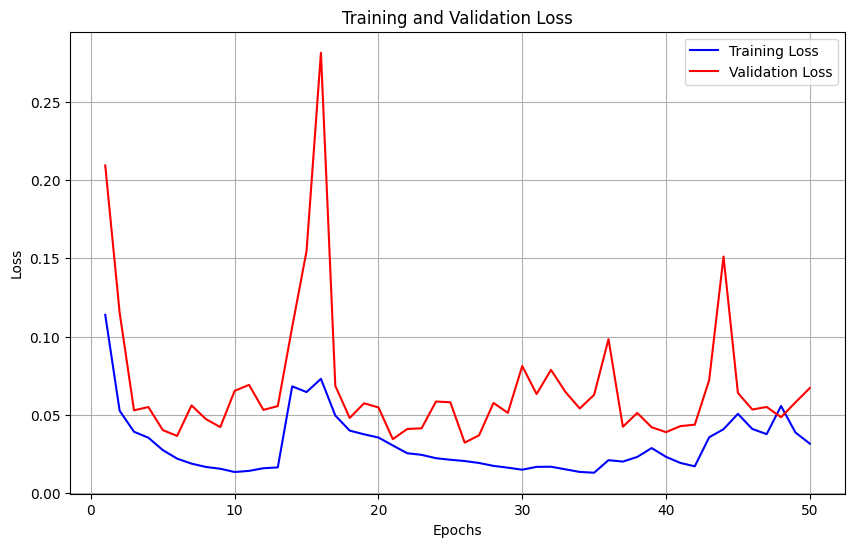

In [ ]:
def plot_training_history(train_loss, test_loss, save_path=None):
    plt.figure(figsize=(10, 6))
    epochs = range(1, len(train_loss) + 1)
    
    plt.plot(epochs, train_loss, 'b-', label='Training Loss')
    plt.plot(epochs, test_loss, 'r-', label='Validation Loss')
    
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    
    if save_path:
        plt.savefig(save_path)
    plt.show()
plot_training_history(training_results["train_loss"], training_results["test_loss"])

In [ ]:
import matplotlib.pyplot as plt
import torch
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
from torchvision.datasets.coco import CocoDetection

def plot(imgs, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            boxes = None
            masks = None
            if isinstance(img, tuple):
                img, target = img
                if isinstance(target, dict):
                    boxes = target.get("boxes")
                    masks = target.get("masks")
                elif isinstance(target, tv_tensors.BoundingBoxes):
                    boxes = target
                else:
                    raise ValueError(f"Unexpected target type: {type(target)}")
            img = F.to_image(img)
            if img.dtype.is_floating_point and img.min() < 0:
                # Poor man's re-normalization for the colors to be OK-ish. This
                # is useful for images coming out of Normalize()
                img -= img.min()
                img /= img.max()

            img = F.to_dtype(img, torch.uint8, scale=True)
            if boxes is not None:
                img = draw_bounding_boxes(img, boxes, colors="yellow", width=3)
            if masks is not None:
                img = draw_segmentation_masks(img, masks.to(torch.bool), colors=["green"] * masks.shape[0], alpha=.65)

            ax = axs[row_idx, col_idx]
            ax.imshow(img.permute(1, 2, 0).numpy(), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

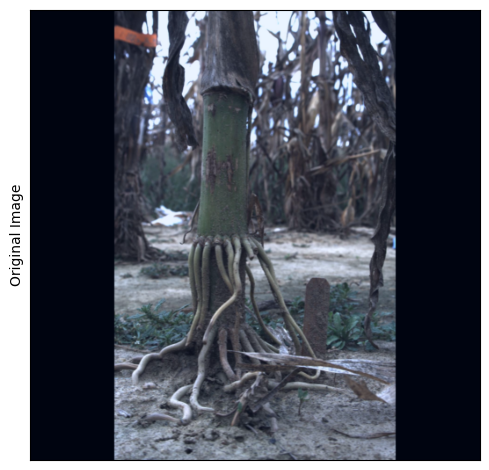

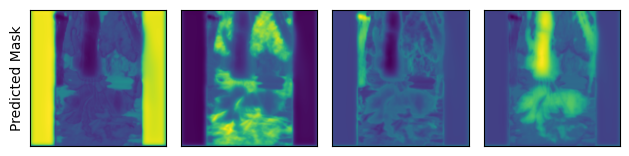

In [ ]:
image, target = full_dataset.test[9]
image = torch.tensor(preprocess_input(image.permute(1, 2, 0).numpy()))
image = image.permute(2, 0, 1).unsqueeze(0).float()
result = model(image.to(device))
plot(image, row_title=["Original Image"])
plot(result.squeeze().detach().cpu().numpy(), row_title=["Predicted Mask"])

In [ ]:
torch.save(training_results["pocket_model"], '/work/multiclass_2023_UNET_sm.pth')